In [3]:
import os
import gdown
import pandas as pd
import xgboost as xgb
import optuna
from src.modules.paths import get_project_root
from sklearn.metrics import r2_score
def download_training_data(id_file, output_folder, output_name):
    url = f"https://drive.google.com/uc?id={id_file}"
    os.makedirs(output_folder, exist_ok=True)
    gdown.download(url, output_folder + output_name, quiet=False)
    
def load_data(input_folder, input_name):
    df = pd.read_feather(input_folder + input_name)
    df["target_10_multiplied"] = df["target_10"]*1000
    df["target_20_multiplied"] = df["target_20"]*1000
    # training, test, validation
    return df[df.type=="training"], df[df.type=="validation"], df[df.type=="validation_unseen"]

In [4]:
file, folder = "training_all_crypto.feather", "temp/"

In [49]:
# Download data
old = "15VkzDb8sfWTDOl44ODmkNS20KEszWUb-"
with_more_val = "1UPdkPOUWegatXlDNrkYrT-vKghr6yeJO"
download_training_data(with_more_val, folder, file)

Downloading...
From: https://drive.google.com/uc?id=1UPdkPOUWegatXlDNrkYrT-vKghr6yeJO
To: /Users/pablocanadapereira/Desktop/Projects/trading/trading/notebooks/temp/training_all_crypto.feather
100%|██████████| 398M/398M [00:09<00:00, 41.1MB/s] 


In [6]:
df_training, df_val, df_val_unseen = load_data(folder, file)
columns_features = [col for col in df_training.columns if col.startswith("feature")]
#columns_target = [col for col in df_training.columns if col.startswith("target")]
columns_target = ["target_10_multiplied"]

In [51]:
df_training_optuna = df_training.sample(10000)

In [9]:

def objective(trial):
    # 1. Suggest values of the hyperparameters using a trial object.
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1,100, log=True),
        "max_depth": trial.suggest_int("max_depth", 2,20),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001,0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.5,1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0,1),
    }

    # 2. Define model
    model =xgb.XGBRegressor(**param,
    n_jobs=-1,
    )
    # 3. Train
    model.fit(df_training_optuna[columns_features].astype("float32"), df_training_optuna[columns_target].astype("float32"))
    # 4. Evaluate
    df_val_eval = pd.DataFrame(index=df_val.index)
    df_val_eval["target"] = df_val[columns_target]
    df_val_eval["preds"] = model.predict(df_val[columns_features])
    #data={"target": df_val[columns_target].values], "preds": [model.predict(df_val[columns_features])]})
    corr_val = df_val_eval.corr().values[0][1]
    r2 = r2_score(df_val_eval.target, df_val_eval.preds )
    metric = 0.2*corr_val + 0.8*r2
    print(trial.number)
    print("Corr and r2: ",corr_val, r2)
    print("Metric: ", metric)
    return metric

# 3. Create a study object and optimize the objective function.
from optuna.integration.wandb import WeightsAndBiasesCallback
wandb_kwargs = {"project": "my-project"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
optuna.logging.set_verbosity("ERROR")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[wandbc])

<ipython-input-9-d04d14d46e7a>:36: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Currently logged in as: pab_lo4 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[19:28:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0
Corr and r2:  -0.00824925930737799 -0.0003276106432439363
Metric:  -0.001911940376070747
1
Corr and r2:  0.05994543454383819 -0.06179097519104637
Metric:  -0.03744369324406946
2
Corr and r2:  0.058890347090713564 -0.0002768780756354783
Metric:  0.01155656695763433
[19:28:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some

In [10]:
optuna.importance.get_param_importances(study)

OrderedDict([('learning_rate', 0.4963248218148731),
             ('subsample', 0.25010413132945525),
             ('colsample_bytree', 0.1704584563654078),
             ('n_estimators', 0.03362920644970622),
             ('max_depth', 0.03263528873573839),
             ('booster', 0.016043420165382627),
             ('alpha', 0.000654652203884204),
             ('lambda', 0.0001500229355524916)])

# Train final model and check

In [52]:
study.best_params

{'booster': 'gblinear',
 'lambda': 1.0205834584711812e-08,
 'alpha': 9.042705003095993e-08,
 'n_estimators': 11,
 'max_depth': 4,
 'learning_rate': 0.05254899953091593,
 'subsample': 0.9553321221042272,
 'colsample_bytree': 0.260497335738792}

In [53]:
test_size = 10000

In [7]:
from src.core.features.utils import feature_pipeline, add_domain_features
import matplotlib.pyplot as plt

In [18]:
best_params = {'booster': 'gblinear',
 'lambda': 1.0205834584711812e-08,
 'alpha': 9.042705003095993e-08,
 'n_estimators': 11,
 'max_depth': 4,
 'learning_rate': 0.05254899953091593,
 'subsample': 0.9553321221042272,
 'colsample_bytree': 0.260497335738792}

In [19]:
best_params = study.best_trial.params
print(best_params)

NameError: name 'study' is not defined

In [20]:
# double check
#df_training_sampled = df_training.iloc[:-test_size]
#df_test_init = df_training.iloc[-test_size:][["open", "high", "low", "close", "vwap", "volume"]]

In [2]:
#df_val_unseen

In [11]:
#df_training_sampled

In [9]:
df_training_sampled = df_training
df_test_init = df_val_unseen[["open", "high", "low", "close", "vwap", "volume", "pair_name"]]

In [54]:
df_test = pd.DataFrame()
df_target = pd.DataFrame()
for pair_name, group in df_test_init.groupby("pair_name"):
    df_test_aux, _=feature_pipeline(group, include_target=False)
    df_test = pd.concat([df_test, df_test_aux])
    df_target = pd.concat([df_target, df_val_unseen[df_val_unseen.pair_name==pair_name].iloc[400:]])

In [25]:
df_target

,index,Unnamed: 0,date,time,open,high,low,close,vwap,volume,...,feature_domain_31,feature_domain_32,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37,type,pair_name,target_10_multiplied
516324,65685,65685,2021-11-08 04:09:00,1636344540,1.761791,1.761791,1.761791,1.761791,0.00000,0.000000,...,-0.002256,-0.002149,-0.001652,-0.007442,-0.004271,0.008532,0.007706,validation_unseen,adaeur,-0.685763
516325,65686,65686,2021-11-08 04:10:00,1636344600,1.762080,1.762792,1.762080,1.762792,1.76278,610.753166,...,-0.002092,-0.001986,-0.001799,-0.007336,-0.004107,0.009371,0.007468,validation_unseen,adaeur,-0.521271
516326,65687,65687,2021-11-08 04:11:00,1636344660,1.762830,1.762830,1.762830,1.762830,1.76283,316.689515,...,-0.001667,-0.001872,-0.001957,-0.007092,-0.004157,0.010137,0.007979,validation_unseen,adaeur,0.185532
516327,65688,65688,2021-11-08 04:12:00,1636344720,1.762830,1.762830,1.762830,1.762830,0.00000,0.000000,...,-0.001370,-0.001917,-0.002279,-0.007092,-0.004458,0.009445,0.007407,validation_unseen,adaeur,0.185532
516328,65689,65689,2021-11-08 04:13:00,1636344780,1.762830,1.762830,1.762830,1.762830,0.00000,0.000000,...,-0.001370,-0.001641,-0.002568,-0.005456,-0.004801,0.009705,0.007628,validation_unseen,adaeur,-0.096427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583176,66253,66253,2021-11-08 14:03:00,1636380180,1.077750,1.077750,1.076950,1.077450,1.07720,2143.629307,...,0.000622,-0.009303,-0.010957,-0.012389,-0.012136,-0.014367,-0.029194,validation_unseen,xrpeur,-2.683570
583177,66254,66254,2021-11-08 14:04:00,1636380240,1.077090,1.077490,1.075550,1.075570,1.07623,8948.651292,...,-0.000603,-0.009736,-0.011472,-0.010482,-0.012288,-0.014313,-0.028423,validation_unseen,xrpeur,-3.211298
583178,66255,66255,2021-11-08 14:05:00,1636380300,1.075780,1.076890,1.075780,1.076890,1.07651,1120.958896,...,-0.001383,-0.011032,-0.013191,-0.012140,-0.012665,-0.015539,-0.028325,validation_unseen,xrpeur,-4.340704
583179,66256,66256,2021-11-08 14:06:00,1636380360,1.076690,1.076690,1.076690,1.076690,1.07669,43.803280,...,0.000158,-0.010859,-0.012610,-0.011812,-0.010859,-0.014201,-0.026809,validation_unseen,xrpeur,-3.590698


In [26]:
df_test

,open,high,low,close,vwap,volume,pair_name,open_norm,close_norm,high_norm,...,feature_domain_28,feature_domain_29,feature_domain_30,feature_domain_31,feature_domain_32,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37
0,1.761791,1.761791,1.761791,1.761791,0.00000,0.000000,adaeur,1.0,1.000000,1.000000,...,-0.000224,0.000346,-0.000416,-0.002256,-0.002149,-0.001652,-0.007442,-0.004271,0.008532,0.007706
1,1.762080,1.762792,1.762080,1.762792,1.76278,610.753166,adaeur,1.0,1.000404,1.000404,...,0.000089,0.000700,-0.000252,-0.002092,-0.001986,-0.001799,-0.007336,-0.004107,0.009371,0.007468
2,1.762830,1.762830,1.762830,1.762830,1.76283,316.689515,adaeur,1.0,1.000000,1.000000,...,0.000590,0.000365,0.000010,-0.001667,-0.001872,-0.001957,-0.007092,-0.004157,0.010137,0.007979
3,1.762830,1.762830,1.762830,1.762830,0.00000,0.000000,adaeur,1.0,1.000000,1.000000,...,0.000590,0.000514,-0.000002,-0.001370,-0.001917,-0.002279,-0.007092,-0.004458,0.009445,0.007407
4,1.762830,1.762830,1.762830,1.762830,0.00000,0.000000,adaeur,1.0,1.000000,1.000000,...,0.000426,0.000590,0.000629,-0.001370,-0.001641,-0.002568,-0.005456,-0.004801,0.009705,0.007628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1.077750,1.077750,1.076950,1.077450,1.07720,2143.629307,xrpeur,1.0,0.999722,1.000000,...,0.005364,0.003305,0.003006,0.000622,-0.009303,-0.010957,-0.012389,-0.012136,-0.014367,-0.029194
595,1.077090,1.077490,1.075550,1.075570,1.07623,8948.651292,xrpeur,1.0,0.998589,1.000371,...,0.002737,0.003195,0.003793,-0.000603,-0.009736,-0.011472,-0.010482,-0.012288,-0.014313,-0.028423
596,1.075780,1.076890,1.075780,1.076890,1.07651,1120.958896,xrpeur,1.0,1.001032,1.001032,...,0.000270,0.003526,0.003498,-0.001383,-0.011032,-0.013191,-0.012140,-0.012665,-0.015539,-0.028325
597,1.076690,1.076690,1.076690,1.076690,1.07669,43.803280,xrpeur,1.0,1.000000,1.000000,...,-0.000984,0.002365,0.002897,0.000158,-0.010859,-0.012610,-0.011812,-0.010859,-0.014201,-0.026809


In [56]:
#compute_RSI(df_test_init, "open", 100) # it is not
#add_domain_features(df_test_init, "open").iloc[-1:].isnull().sum()


In [60]:
#df_test

In [59]:
#df_test_init

In [61]:
#df_test[columns_features].columns

In [12]:
df_training_sampled.date.max()

Timestamp('2021-11-07 21:28:00')

In [55]:
final_model =xgb.XGBRegressor(**best_params,
    n_jobs=-1,
    )
final_model.fit(df_training_sampled[columns_features].astype("float32"), df_training_sampled[columns_target].astype("float32"))

[20:54:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=9.042705003095993e-08, base_score=0.5, booster='gblinear',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.260497335738792, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             lambda=1.0205834584711812e-08, learning_rate=0.05254899953091593,
             max_delta_step=None, max_depth=4, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=11, n_jobs=-1,
             num_parallel_tree=None, random_state=0, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, subsample=0.9553321221042272, tree_method=None,
             validate_parameters=1, verbosity=None)

In [7]:
import pickle

In [56]:
# Serialize
import pickle
with open("wow_20.pickle", "wb") as f:
    pickle.dump(final_model,f)
    

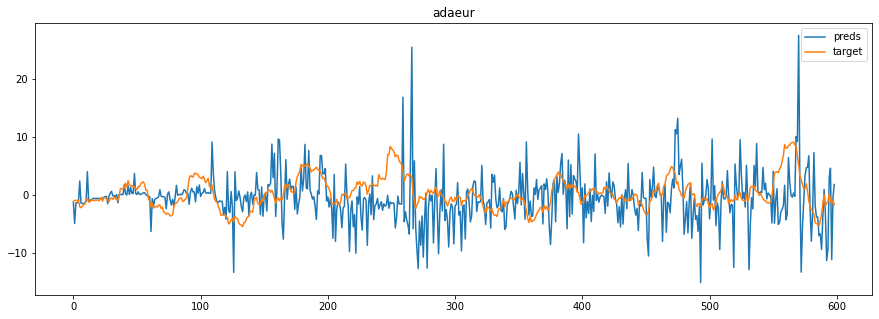

0.20874088096595994
0.0330885411367845


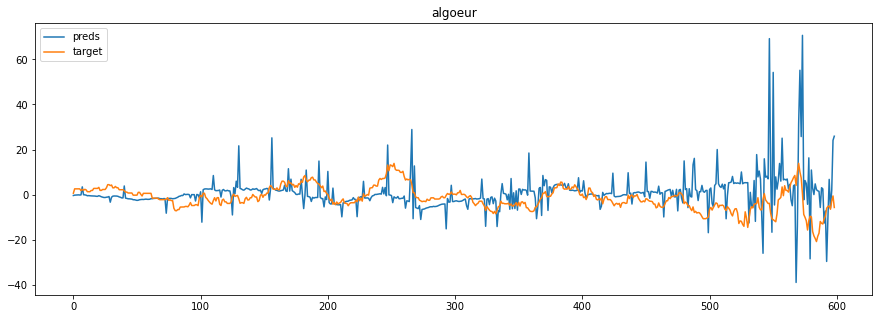

0.05182618022339527
-0.09919950502298347


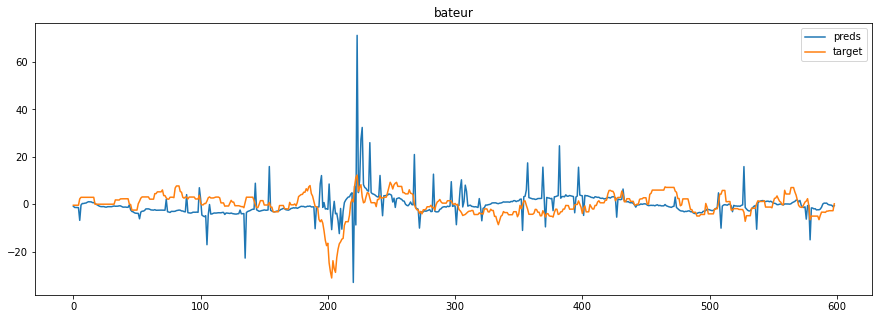

0.1285750542790575
0.015436762374183455


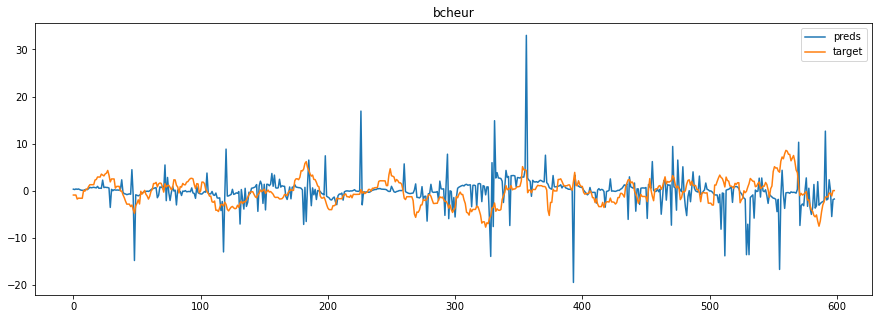

0.09616827797589285
0.001569321423774639


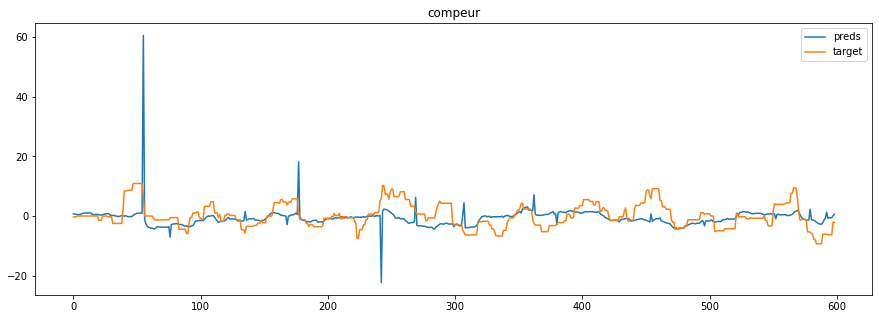

0.18741728340336863
0.021979865729231718


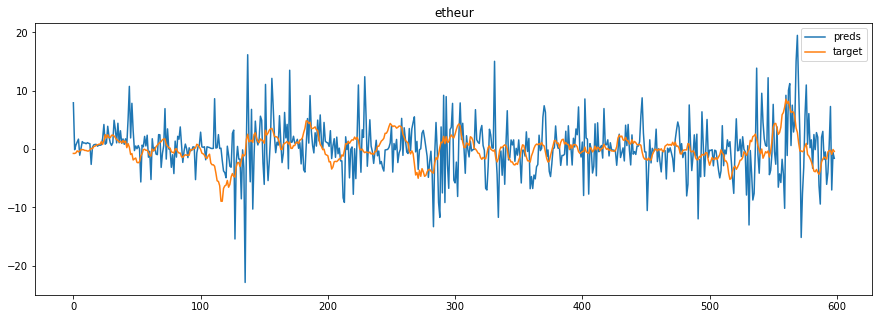

0.21323935099245866
0.04500111273866336


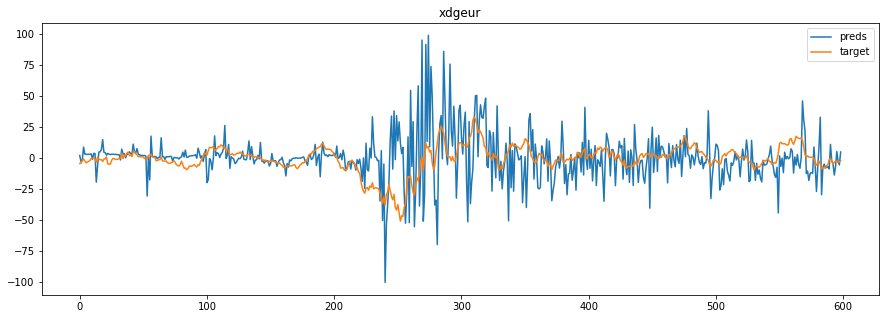

0.22151849340199248
0.04237704197145975


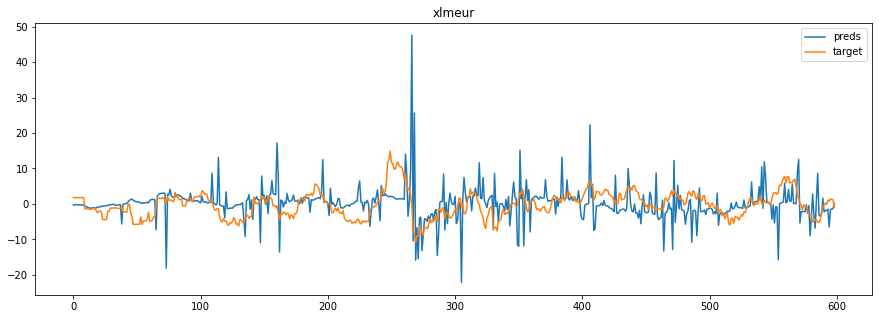

0.1960527784475387
0.029446236154600847


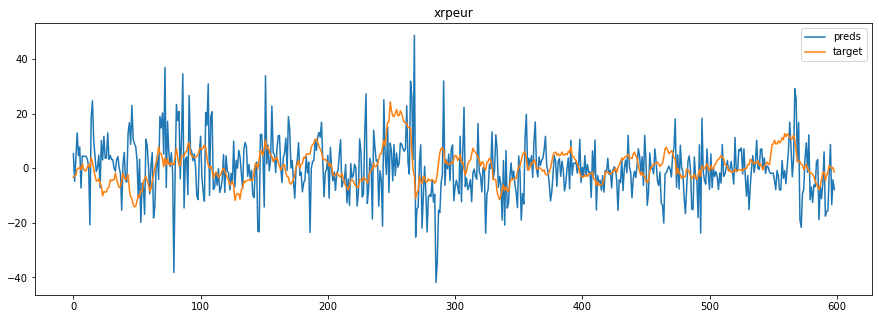

0.208213606915394
0.02964484102394971


In [58]:
for pair_name in df_test.pair_name.unique():
    plt.figure(figsize=(15,5))
    preds = model.predict(df_test[df_test.pair_name==pair_name][columns_features])
    target = df_target[df_target.pair_name==pair_name]["target_20"]*1000
    plt.plot(preds*10, label="preds")
    plt.plot(target.values, label="target")
    #plt.xlim([0,10000])
    plt.legend()
    plt.title(pair_name)
    plt.show()
    print(pd.DataFrame(data={"preds": preds, "target": target}).corr().values[0][1])
    print(r2_score(target,preds ))

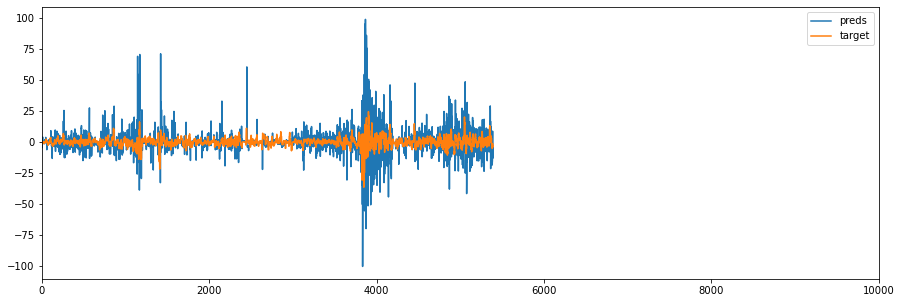

0.23536851158779049
0.05447733521949427


In [59]:
plt.figure(figsize=(15,5))
preds = final_model.predict(df_test[columns_features])
target = df_target["target_10"]*1000
plt.plot(preds*10, label="preds")
plt.plot(target.values, label="target")
plt.xlim([0,10000])
plt.legend()
plt.show()
print(pd.DataFrame(data={"preds": preds, "target": target}).corr().values[0][1])
print(r2_score(target,preds ))

In [4]:
#Deserialize
import pickle
import pandas as pd
with open("wow_20.pickle" ,'rb') as f:
    model = pickle.load(f)

In [7]:
# test real data
#eth
df = pd.read_csv(get_project_root() / "data" / "test_model" / "etheur.csv")

In [25]:
# backtesting
df_eth, _=feature_pipeline(df, include_target=True, target_list=[1, 10,20])


In [26]:
columns_features = [col for col in df_eth.columns if col.startswith("feature")]

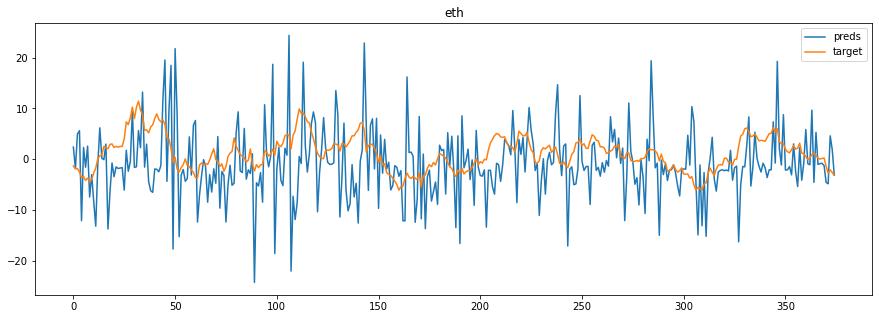

0.25859754389151834
-0.07080210503544615


In [27]:
plt.figure(figsize=(15,5))
preds = model.predict(df_eth[columns_features])
target = df_eth["target_20"]*1000
plt.plot(preds*10, label="preds")
plt.plot(target.values, label="target")
#plt.xlim([0,10000])
plt.legend()
plt.title("eth")
plt.show()
print(pd.DataFrame(data={"preds": preds, "target": target}).corr().values[0][1])
print(r2_score(target,preds ))

In [33]:
4104.85/4103.58

1.000309485863563

In [31]:
df_backtesting[["open", "target_1"]]

,open,target_1
0,4104.85,0.000309
1,4103.58,-0.000024
2,4103.68,0.000651
3,4101.01,0.001164
4,4096.24,-0.000220
...,...,...
370,4012.83,-0.000319
371,4014.11,-0.000471
372,4016.00,0.000648
373,4013.40,0.000563


In [30]:
df_backtesting = df_eth.copy()
df_backtesting["preds"] = model.predict(df_eth[columns_features])/1000

<AxesSubplot:>

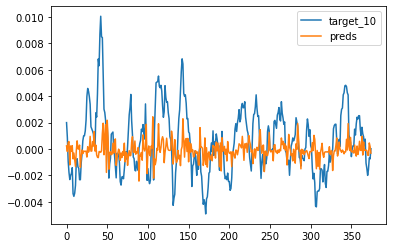

In [83]:
df_backtesting[["target_10", "preds"]].plot()

In [84]:
# backtesting
threshold = 0.001
next_action = "buy"
df_backtesting["action"] = None
for index, row in df_backtesting.iterrows():
    if (-row["preds"] > threshold) and (next_action=="buy"):
        df_backtesting.loc[df_backtesting.index==index, "action"] = "buy"
        next_action = "sell"
    elif (-row["preds"] < -threshold) and (next_action=="sell"):
        df_backtesting.loc[df_backtesting.index==index, "action"] = "sell"
        next_action = "buy"


<AxesSubplot:>

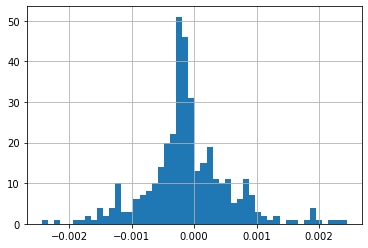

In [85]:
df_backtesting.preds.hist(bins=50)

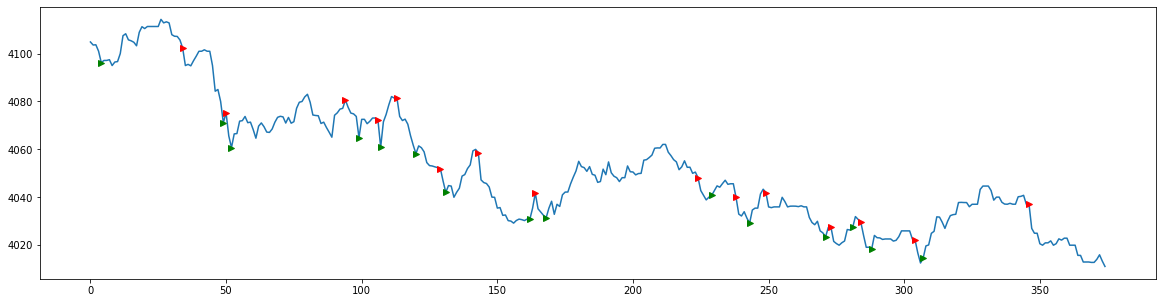

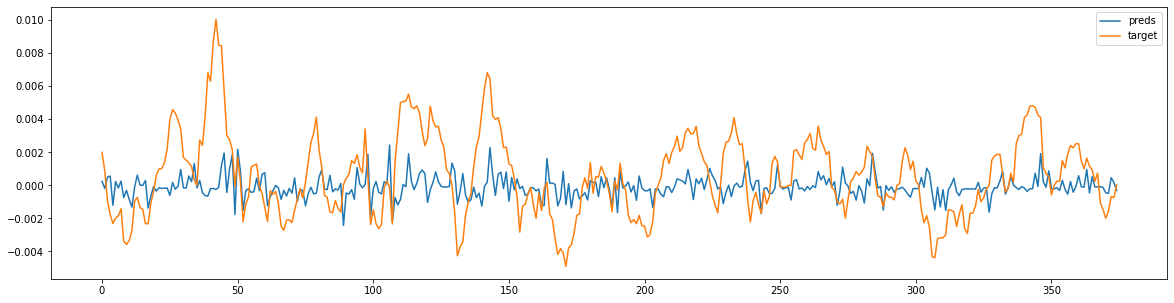

In [86]:
#plt.plot(df_backtesting.preds)
#plt.plot(df_backtesting.target_10)
plt.figure(figsize=(20,5))
plt.plot(df_backtesting.open)
plt.plot(df_backtesting[df_backtesting.action=="sell"].open, ">r")
plt.plot(df_backtesting[df_backtesting.action=="buy"].open, ">g")
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtesting.preds, label="preds")
plt.plot(df_backtesting.target_10, label="target")
plt.legend()
plt.show()

In [87]:
df_backtesting["sum"] = None
fee = 0.0016
df_backtesting.loc[(df_backtesting.action=="buy"), "sum"] = -df_backtesting[df_backtesting.action=="buy"].open*(1+fee)
df_backtesting.loc[(df_backtesting.action=="sell"), "sum"] = df_backtesting[df_backtesting.action=="sell"].open*(1-fee)

In [88]:
df_backtesting["sum"].notnull().sum()

30

In [89]:
df_backtesting["sum"].sum()

-54.509984000005716

In [127]:
df.date.max()

'2021-11-15 19:35:00'

In [34]:
df_eth.date.max()

'2021-11-15 19:25:00'

In [35]:
df_eth[[col for col in df_eth.columns if col.startswith("target")]]

,target_10
0,0.001999
1,0.000873
2,-0.000918
3,-0.001770
4,-0.002314
...,...
305,-0.002548
306,-0.004330
307,-0.004380
308,-0.003234


In [84]:
preds

array([-0.03915908, -0.4333064 , -0.05306786, ..., -1.2282135 ,
       -0.23647493, -0.63899904], dtype=float32)

In [27]:
df_plot_test = get_df_plot(df_val, final_model, pytorch=False)
plot_results(df_plot_test)

NameError: name 'get_df_plot' is not defined

In [38]:
final_model =xgb.XGBRegressor(**study.best_trial.params,
    learning_rate=0.1,
    n_jobs=-1,
    subsample=0.9,
    colsample_bytree=0.1,
    )
    # 3. Train
final_model.fit(df_training[columns_features].astype("float32"), df_training[columns_target].astype("float32"))

[19:35:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=5.146496638539848e-05, base_score=0.5, booster='gblinear',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             lambda=1.0316183369767604e-08, learning_rate=0.1,
             max_delta_step=None, max_depth=3, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=4, n_jobs=-1,
             num_parallel_tree=None, random_state=0, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, subsample=0.9, tree_method=None,
             validate_parameters=1, verbosity=None)

In [2]:
def get_df_plot(df, model, pytorch=True):
    df_plot = df.reset_index()[columns_target].rename(columns={columns_target[0]:"target"})
    if pytorch:
        df_plot["preds"] = model.predict(df, columns_features, cpu_dev)
    else:
        df_plot["preds"] = model.predict(df[columns_features])
                                    
    return df_plot
def plot_results(df, xlim=None):
    fig, axs = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [3, 1]})
    axs[0].plot(df["preds"], label="preds")
    axs[0].plot(df["target"],label= "target", alpha=0.5)
    if xlim:
        axs[0].set_xlim(xlim)
    axs[0].legend()
    axs[1].plot(df.preds, df.target, "o", alpha=0.5)
    print("corr: ", df.corr().values[0][1])
    print("r2: ", r2_score(df.target,df.preds ))

In [3]:
df_plot_val = get_df_plot(df_val, final_model, pytorch=False)
df_plot_val_unseen = get_df_plot(df_val_unseen, final_model, pytorch=False)


NameError: name 'df_val' is not defined

corr:  0.30000491070842966
r2:  0.08820782881052547


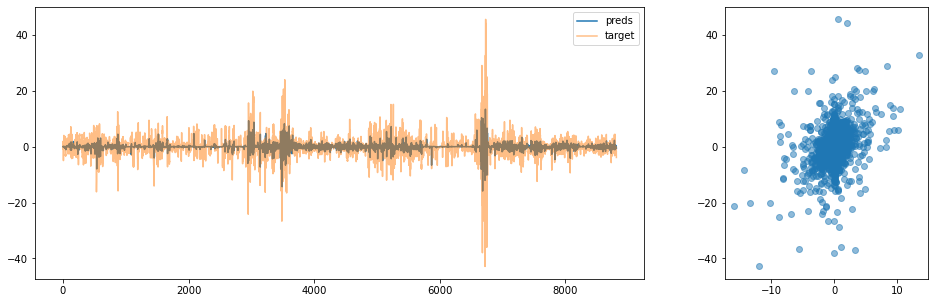

In [48]:
plot_results(df_plot_val)

In [1]:
plot_results(df_plot_val_unseen)

NameError: name 'plot_results' is not defined

In [ ]:
plot_results(df_plot_val_unseen, xlim=[100,1000])

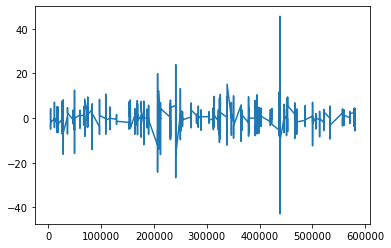

In [39]:
import matplotlib.pyplot as plt
df_plot_val = get_df_plot(df_validation, model, pytorch=False)